In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from data import data_reader

Tensor = torch.Tensor
rand_m = np.random.random

In [2]:
MODEL_NAME = 'densenet121_cos'
if not os.path.exists('weights/'):
    !mkdir weights
if not os.path.exists('weights/{}'.format(MODEL_NAME)):
    !mkdir weights/{MODEL_NAME}

In [3]:
class model_densenet(nn.Module):
    def __init__(self, num_class):
        super(model_densenet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        #self.avgp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1000, num_class)
    
    def forward(self, x):
        x = self.densenet(x)
        #print(x.shape)
        #x = self.avgp(x)
        #print(x.shape)
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        return x

In [4]:
model = model_densenet(6).to('cuda')

/data/tennant/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [5]:
init_lr = 0.001
n_cycle = 6
epoch_per_cycle = 10
cycle_add = 1.5
def cos_annealing_lr(initial_lr, cur_epoch, epoch_per_cycle):
    return initial_lr * (np.cos(np.pi * cur_epoch / epoch_per_cycle) + 1) / 2

In [6]:
optim = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [7]:
from data import data_reader
class args:
    bs = 64
    path = 'train2000/'

dr = data_reader(args, 'train2000/train2000.csv')

train_loader, test_loader = dr.get_train_loader()

In [8]:
train_loss_rec = []
train_acc_rec = []
test_loss_rec = []
test_acc_rec = []
best_acc = 0
lr_list = []
for cycle in range(n_cycle):
    print('Snatshot# ', cycle)
    epoch_per_cycle += cycle_add
    for epoch in range(int(epoch_per_cycle)):
        epoch_loss = 0
        total, correct = 0, 0
        lr = cos_annealing_lr(init_lr, epoch, epoch_per_cycle)
        optim.state_dict()['param_groups'][0]['lr'] = lr
        lr_list.append(lr)
        print('\rCycle {} | Epoch # {} | lr = {}'.format(cycle, epoch, lr))
        for batch_idx, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
            optim.zero_grad()
            y_hat = model(X_train)
            loss = loss_func(y_hat, torch.max(y_train, 1)[1])
            loss.backward()
            _, pred = torch.max(y_hat.data, 1)
            optim.step()
            correct += (pred == torch.max(y_train, 1)[1]).sum().item()
            total += X_train.size(0)
            epoch_loss += loss.item() / len(train_loader)
            print('\rCycle {} | Epoch {} | Batch # {} Train Loss {:.5f} '.format(cycle, epoch, batch_idx, loss.item()))
        print('\rCycle {} | Epoch {} | Epoch Train Loss {:.5f}'.format(cycle, epoch, epoch_loss))
        epoch_acc = correct / total * 100
        print('\nCycle {} | Epoch {} | Epoch Train Acc {:.3f}%'.format(cycle, epoch, epoch_acc))
        train_loss_rec.append(epoch_loss)
        train_acc_rec.append(epoch_acc)
        with torch.no_grad():
            test_epoch_loss = 0
            test_total = 0
            test_correct = 0
            
            for batch_idx, (X_val, y_val) in enumerate(test_loader):
                X_val, y_val = X_val.to('cuda'), y_val.to('cuda')
            
                y_hat = model(X_val)
                loss = loss_func(y_hat, torch.max(y_val, 1)[1])
                _, pred = torch.max(y_hat.data, 1)
                print(pred[:5])
                print(pred.shape)
                test_total += y_val.size(0)
                test_correct += (pred == torch.max(y_val, 1)[1]).sum().item()
                test_epoch_loss += loss.item() / len(test_loader)
             
            test_epoch_acc = test_correct / test_total * 100
            if test_epoch_acc > best_acc:
                best_acc = test_epoch_acc
                torch.save(model.state_dict(), 'weights/' + MODEL_NAME + '/best_params_acc{}.pth'.format(best_acc)) 
            print('Cycle {} | Epoch {} | Epoch Val Loss {:.5f}'.format(cycle, epoch, test_epoch_loss))
            print('Cycle {} | Epoch {} | Epoch Val Acc {:.3f}%'.format(cycle, epoch, test_epoch_acc))
            
            test_loss_rec.append(test_epoch_loss)
            test_acc_rec.append(test_epoch_acc)
    cycle_add *= 1.5

Snatshot#  0
Cycle 0 | Epoch # 0 | lr = 0.001
Cycle 0 | Epoch 0 | Batch # 0 Train Loss 2.15607 
Cycle 0 | Epoch 0 | Batch # 1 Train Loss 1.19303 
Cycle 0 | Epoch 0 | Batch # 2 Train Loss 0.60125 
Cycle 0 | Epoch 0 | Batch # 3 Train Loss 0.87978 
Cycle 0 | Epoch 0 | Batch # 4 Train Loss 1.19346 
Cycle 0 | Epoch 0 | Batch # 5 Train Loss 0.47545 
Cycle 0 | Epoch 0 | Batch # 6 Train Loss 0.41624 
Cycle 0 | Epoch 0 | Batch # 7 Train Loss 0.49204 
Cycle 0 | Epoch 0 | Batch # 8 Train Loss 0.54693 
Cycle 0 | Epoch 0 | Batch # 9 Train Loss 0.91840 
Cycle 0 | Epoch 0 | Batch # 10 Train Loss 0.77157 
Cycle 0 | Epoch 0 | Batch # 11 Train Loss 0.41478 
Cycle 0 | Epoch 0 | Batch # 12 Train Loss 0.69130 
Cycle 0 | Epoch 0 | Batch # 13 Train Loss 0.54440 
Cycle 0 | Epoch 0 | Batch # 14 Train Loss 0.59424 
Cycle 0 | Epoch 0 | Batch # 15 Train Loss 0.59723 
Cycle 0 | Epoch 0 | Batch # 16 Train Loss 0.57405 
Cycle 0 | Epoch 0 | Batch # 17 Train Loss 0.60283 
Cycle 0 | Epoch 0 | Batch # 18 Train Loss 0.53

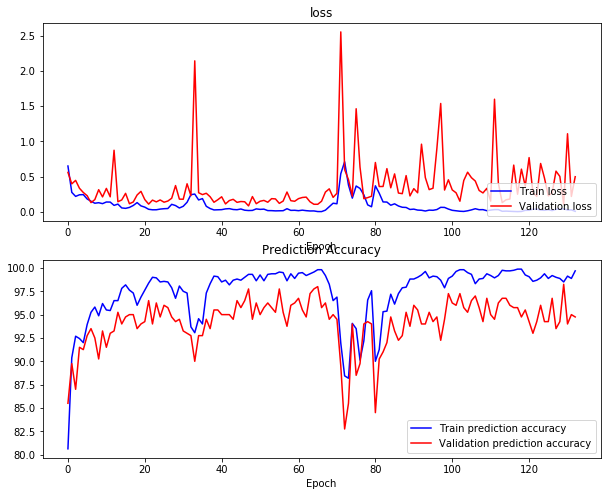

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(train_loss_rec, 'b')
plt.plot(test_loss_rec, 'r')

plt.title('loss')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_acc_rec, 'b')
plt.plot(test_acc_rec, 'r')

plt.title('Prediction Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()

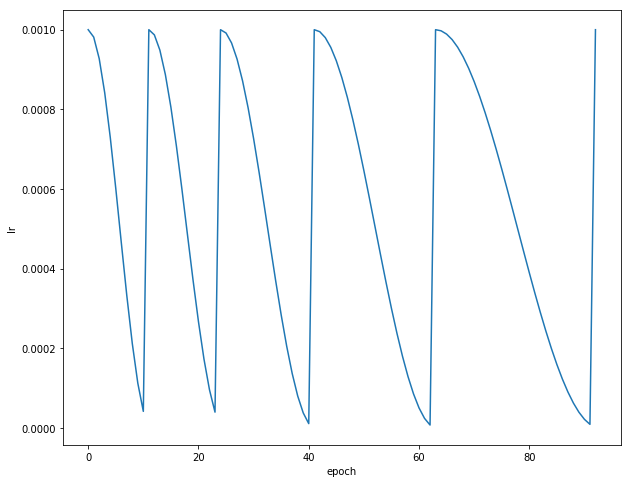

In [10]:
plt.plot(lr_list)
plt.xlabel('epoch')
plt.ylabel('lr')
plt.show()